<a href="https://colab.research.google.com/github/MoritzGuck/All_of_ML-under_construction/blob/master/contradictory-my-dear-watson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FRIST go to Setting (panel on right) and turn on "Internet" (only shows up once you have entered verified your phone number). 

In [ ]:
# TEST

In [2]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import os 
os.getcwd()

'/content'

In [5]:
os.chdir("drive/MyDrive/Kaggle group/Contradictory my dear Watson/data")
os.getcwd()

'/content/drive/MyDrive/Kaggle group/Contradictory my dear Watson/data'

In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import nltk
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
filenames = os.listdir()
print(filenames)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

['sample_submission.csv', 'test.csv', 'train.csv']


In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
#nltk.download()
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 12.0 MB 5.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


# Data Import

In [10]:
raw_train_df = pd.read_csv("train.csv")
raw_test_df = pd.read_csv("test.csv")
sample_submission_df = pd.read_csv("test.csv")

# Data Analysis

## Training Data

In [11]:
# Only available base features are premise, hypothesis and language
raw_train_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [12]:
# No null entries are present
raw_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


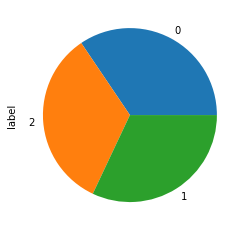

In [13]:
# Labels are rather well balanced overall:
raw_train_df["label"].value_counts().plot.pie()

In [14]:
raw_train_df['language'].unique()

array(['English', 'French', 'Thai', 'Turkish', 'Urdu', 'Russian',
       'Bulgarian', 'German', 'Arabic', 'Chinese', 'Hindi', 'Swahili',
       'Vietnamese', 'Spanish', 'Greek'], dtype=object)

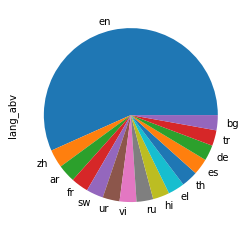

In [15]:
# Language is heavily biased towards english:
raw_train_df["lang_abv"].value_counts().plot.pie()

In [16]:
# also the label counts for the different languages are balanced
languages = raw_train_df["lang_abv"].unique()
label_count_df = pd.DataFrame(columns=['0', '1', '2'], index=languages)

for lang in languages:
    lang_counts = raw_train_df.query("lang_abv == @lang")["label"].value_counts()
    label_count_df.loc[lang, "0"] = lang_counts.loc[0]
    label_count_df.loc[lang, "1"] = lang_counts.loc[1]
    label_count_df.loc[lang, "2"] = lang_counts.loc[2]
label_count_df

,0,1,2
en,2427,2166,2277
fr,133,129,128
th,121,126,124
tr,110,114,127
ur,133,110,138
ru,132,124,120
bg,123,111,108
de,108,116,127
ar,124,129,148
zh,140,146,125


In [17]:
# There are a lot of duplicates in the premises, but very few in the hypotheses:
print("duplicate premise entries: " + str(raw_train_df["premise"].count() - raw_train_df["premise"].nunique()))
print("duplicate hypothesis entries: " + str(raw_train_df["hypothesis"].count() - raw_train_df["hypothesis"].nunique()))

duplicate premise entries: 3911
duplicate hypothesis entries: 1


In [18]:
# Example fore entailment (0), neutral/non conclusive (1) and contradiction (2)
raw_train_df[raw_train_df['premise']=="yeah right right yeah i know i uh i remember my college days  and having to do that too"].sort_values(by='label')

,id,premise,hypothesis,lang_abv,language,label
5395,84dcc46abd,yeah right right yeah i know i uh i remember m...,Back when I was in college I had that as well.,en,English,0
2926,136e775d08,yeah right right yeah i know i uh i remember m...,I didn't have to do that once I left college.,en,English,1
10706,d5208c8969,yeah right right yeah i know i uh i remember m...,I remember that when I went to college we didn...,en,English,2


In [19]:
raw_train_df

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


## Data Cleaning

Replace multi spaces with single space

In [20]:
train_df = raw_train_df # to keep the raw version available later 
train_df.premise = train_df.premise.replace('\s+', ' ', regex=True)
train_df.hypothesis = train_df.hypothesis.replace('\s+', ' ', regex=True)

# Tokenization
**! For now only for english**

In [21]:
train_df = train_df[train_df['language']=='English']

#### Expand Contradiction phrases

A dictionary of the most common contraction words

In [ ]:
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [ ]:
# regex string for matches in hypotheses and premises
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

In [ ]:
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

In [ ]:
train_df['hypothesis']=train_df['hypothesis'].apply(lambda x:expand_contractions(x))
train_df['premise']=train_df['premise'].apply(lambda x:expand_contractions(x))
train_df['hypothesis']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0        The rules developed in the interim were put to...
1        Practice groups are not permitted to work on t...
3        They cannot defend themselves because of their...
7                  From St. Ann is Bay to Cockpit Country.
8        The boss will fire you if he sees you slacking...
                               ...                        
12115    All studies have the same amount of uncertaint...
12116    But there are two kinds of the pleasure of doi...
12117                     It cannot be moved, now or ever.
12118         The model temple complex is at the east end.
12119        Ataturk was the father of the Turkish nation.
Name: hypothesis, Length: 6870, dtype: object

In [ ]:
# Make lower case:
train_df['premise']=train_df['premise'].apply(lambda x: x.lower())
train_df['hypothesis']=train_df['hypothesis'].apply(lambda x: x.lower())
train_df 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,the rules developed in the interim were put to...,en,English,0
1,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,English,2
3,5622f0c60b,you know they cannot really defend themselves ...,they cannot defend themselves because of their...,en,English,0
7,fdcd1bd867,from cockpit country to st. ann is bay,from st. ann is bay to cockpit country.,en,English,2
8,7cfb3d272c,"look, it is your skin, but you are going to be...",the boss will fire you if he sees you slacking...,en,English,1
...,...,...,...,...,...,...
12115,2b78e2a914,the results of even the most well designed epi...,all studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,but there are two kinds of the pleasure of doi...,but there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,the important thing is to realize that it is w...,"it cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,at the west end is a detailed model of the who...,the model temple complex is at the east end.,en,English,2


#### Tokenize

In [ ]:
# Put words into lists
train_df['tokenized_premise'] = train_df.apply(lambda row: nltk.word_tokenize(row['premise']), axis=1)
train_df['tokenized_hypothesis'] = train_df.apply(lambda row: nltk.word_tokenize(row['hypothesis']), axis=1)
train_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,premise,hypothesis,lang_abv,language,label,tokenized_premise,tokenized_hypothesis
0,5130fd2cb5,and these comments were considered in formulat...,the rules developed in the interim were put to...,en,English,0,"[and, these, comments, were, considered, in, f...","[the, rules, developed, in, the, interim, were..."
1,5b72532a0b,these are issues that we wrestle with in pract...,practice groups are not permitted to work on t...,en,English,2,"[these, are, issues, that, we, wrestle, with, ...","[practice, groups, are, not, permitted, to, wo..."
3,5622f0c60b,you know they cannot really defend themselves ...,they cannot defend themselves because of their...,en,English,0,"[you, know, they, can, not, really, defend, th...","[they, can, not, defend, themselves, because, ..."
7,fdcd1bd867,from cockpit country to st. ann is bay,from st. ann is bay to cockpit country.,en,English,2,"[from, cockpit, country, to, st., ann, is, bay]","[from, st., ann, is, bay, to, cockpit, country..."
8,7cfb3d272c,"look, it is your skin, but you are going to be...",the boss will fire you if he sees you slacking...,en,English,1,"[look, ,, it, is, your, skin, ,, but, you, are...","[the, boss, will, fire, you, if, he, sees, you..."
...,...,...,...,...,...,...,...,...
12115,2b78e2a914,the results of even the most well designed epi...,all studies have the same amount of uncertaint...,en,English,2,"[the, results, of, even, the, most, well, desi...","[all, studies, have, the, same, amount, of, un..."
12116,7e9943d152,but there are two kinds of the pleasure of doi...,but there are two kinds of the pleasure of doi...,en,English,0,"[but, there, are, two, kinds, of, the, pleasur...","[but, there, are, two, kinds, of, the, pleasur..."
12117,5085923e6c,the important thing is to realize that it is w...,"it cannot be moved, now or ever.",en,English,2,"[the, important, thing, is, to, realize, that,...","[it, can, not, be, moved, ,, now, or, ever, .]"
12118,fc8e2fd1fe,at the west end is a detailed model of the who...,the model temple complex is at the east end.,en,English,2,"[at, the, west, end, is, a, detailed, model, o...","[the, model, temple, complex, is, at, the, eas..."


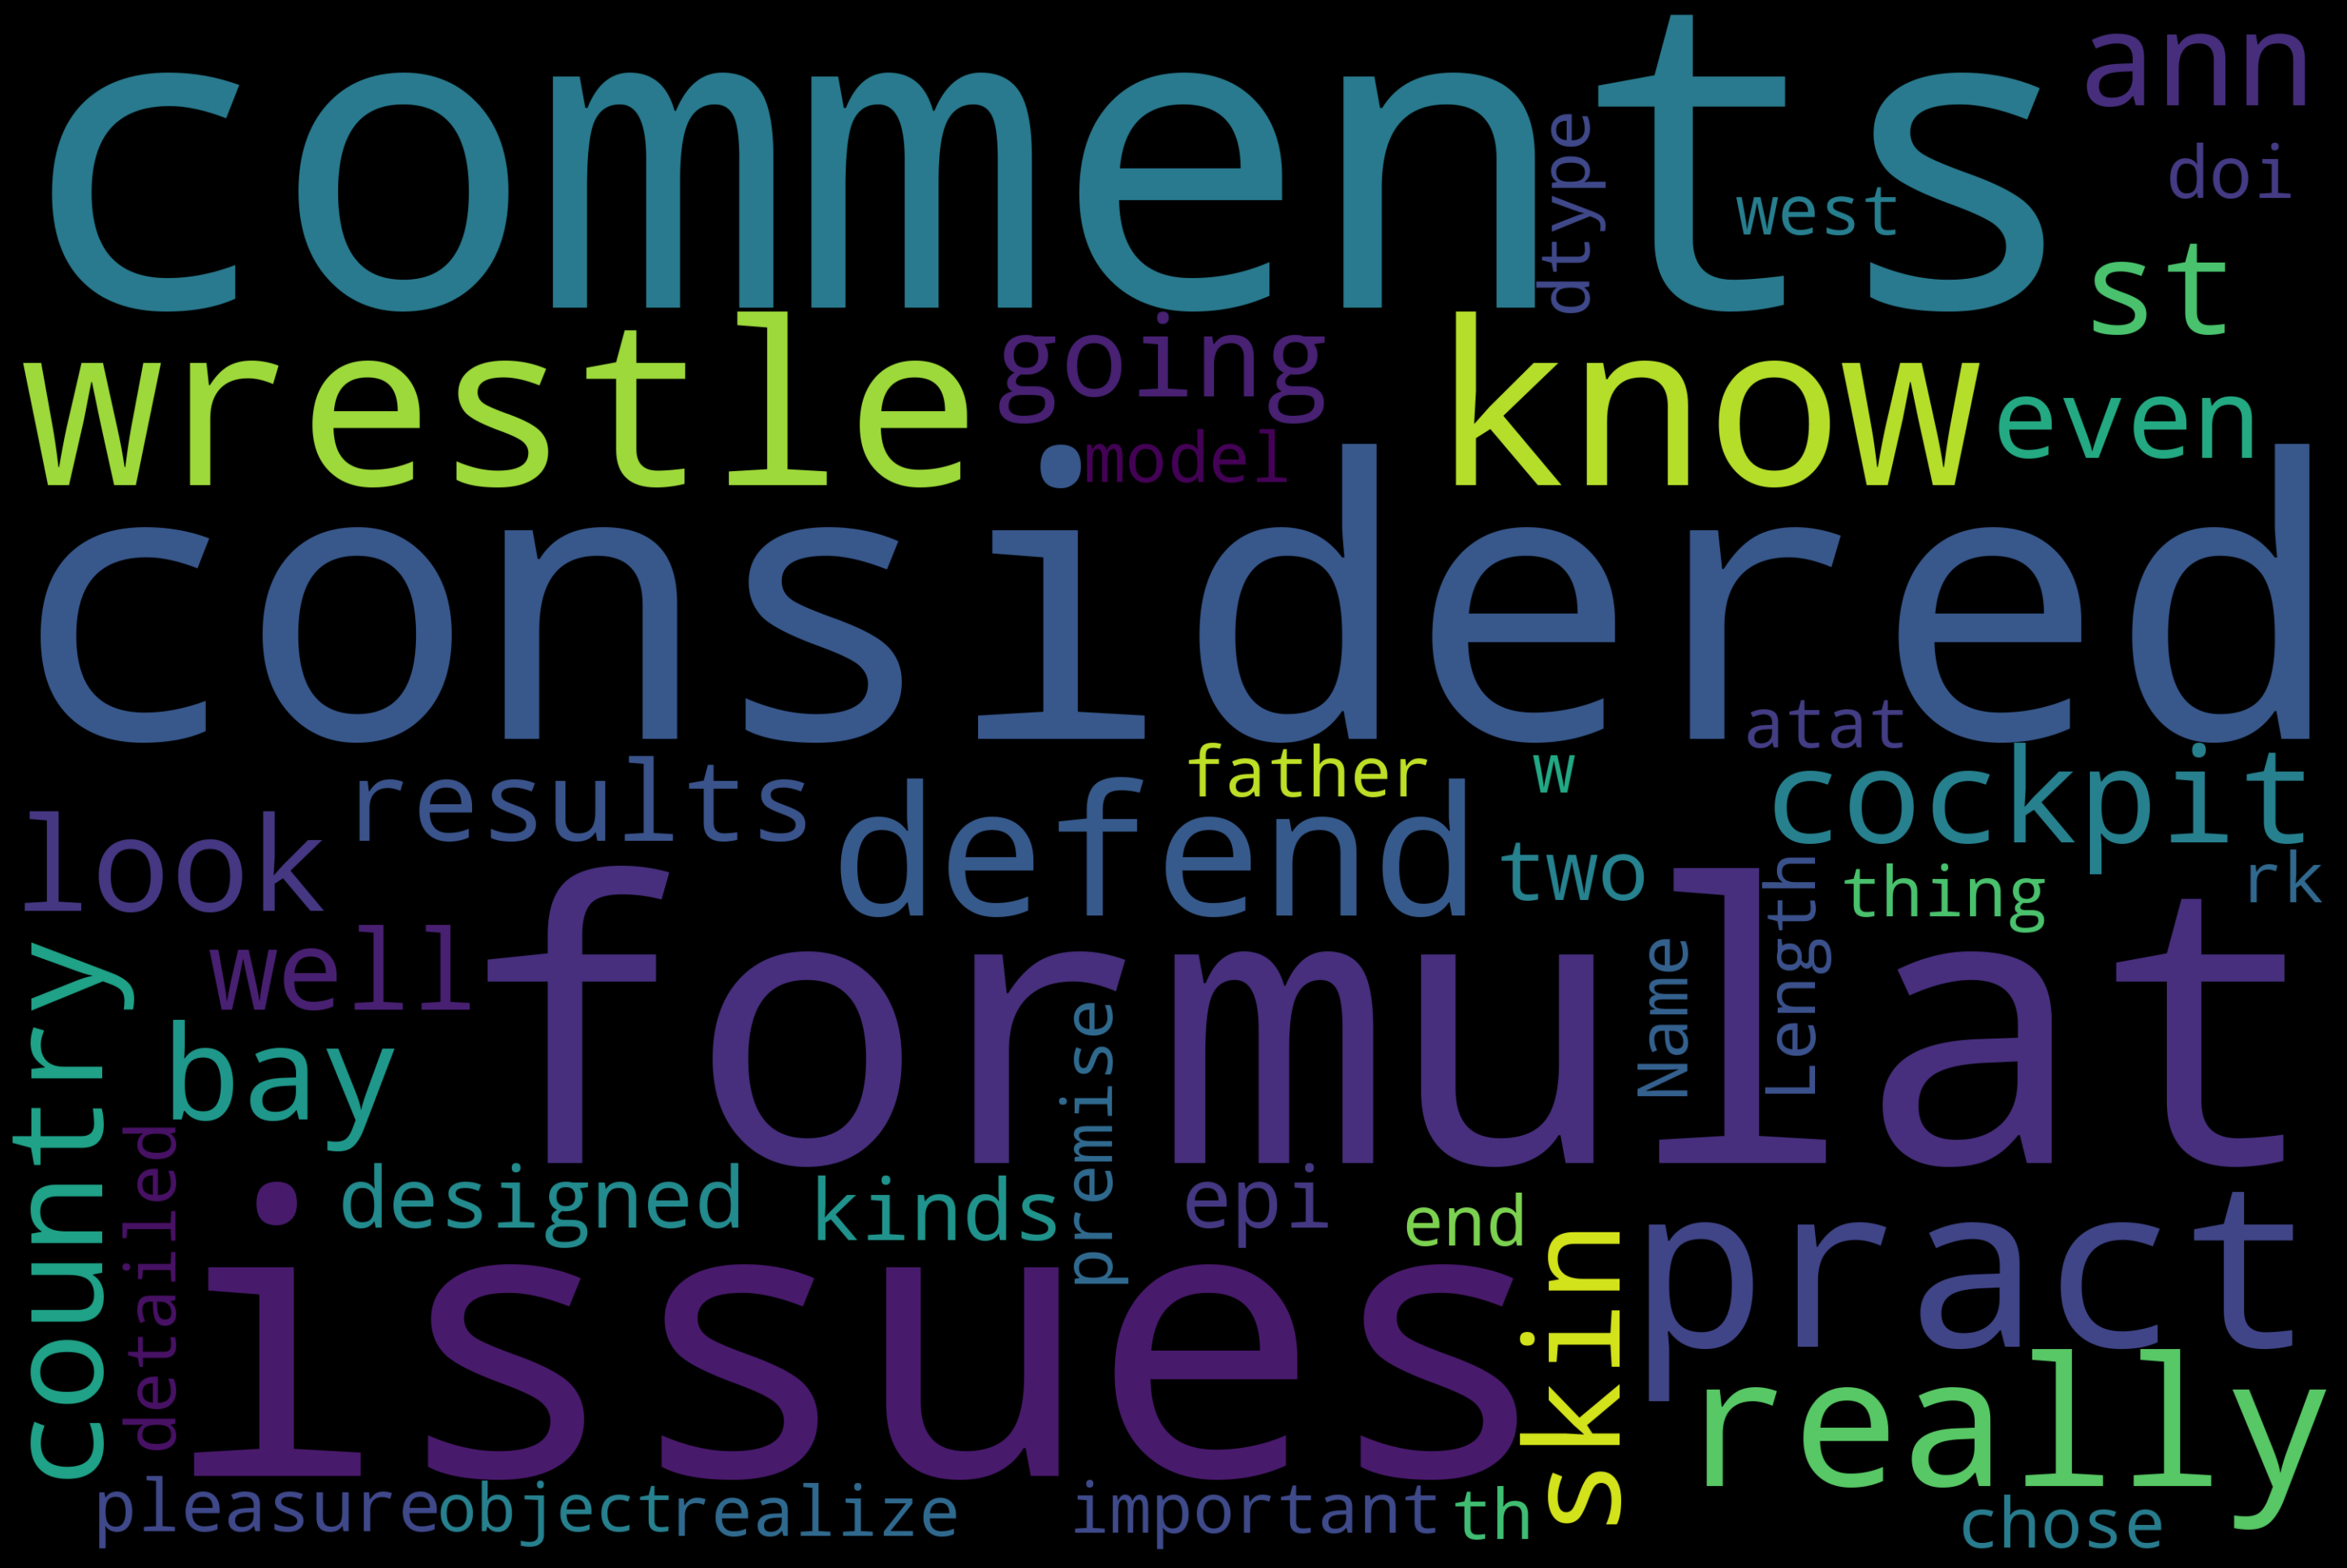

In [ ]:
# Make a wordcloud plot
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(train_df['premise']))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<AxesSubplot:>

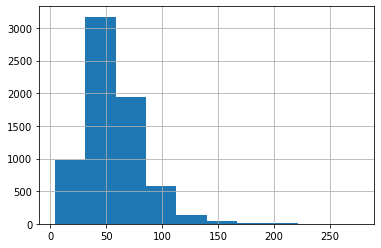

In [ ]:
#number of characters present in each sentence
train_df['hypothesis'].str.len().hist()

<AxesSubplot:>

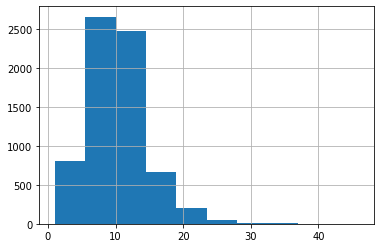

In [ ]:
#number of words in each hypothesis
train_df['hypothesis'].str.split().\
    map(lambda x: len(x)).\
    hist()

<AxesSubplot:>

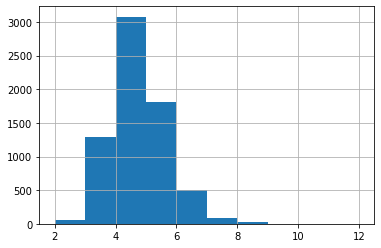

In [ ]:
# Length of words in hypothesis
train_df['hypothesis'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

###  Stopwords

In [22]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
corpus=[]
dd= train_df['hypothesis'].str.split()
dd=dd.values.tolist()
corpus=[word for i in dd for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

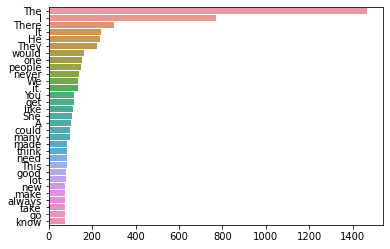

In [24]:
from collections import Counter
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:100]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

In [29]:
## There seems to be an error in the current packge
#from pandas_profiling import ProfileReport

#report_html = ProfileReport(train_df)
#report_html